<a href="https://colab.research.google.com/github/machar94/stockprediction/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Model-Optimization" data-toc-modified-id="Model-Optimization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Model Optimization</a></span></li></ul></div>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


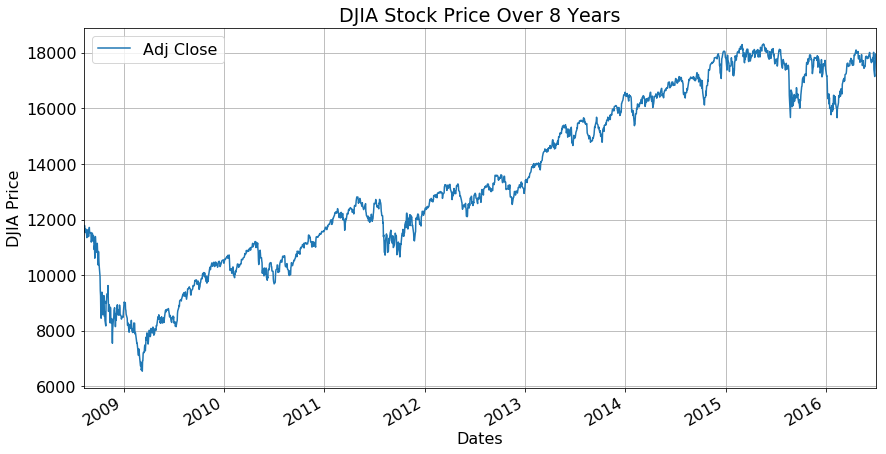

In [35]:
import numpy as np
import warnings
from os.path import isfile, join
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

# Open the data file
data_path  = 'data/'
filename   = 'djia.csv'
full_path  = join(data_path, filename)
assert(isfile(full_path))

# Reads in data and checks to see none of the data is null
df = pd.read_csv(full_path)
assert(df.isnull().sum().sum() == 0)

# Processes file so that data is indexed by date
df = df.sort_values(by='Date')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(11,5))
ax = fig.add_axes([0,0,1,1])
df.plot(y='Adj Close',ax=ax)
ax.set_xlabel('Dates')
ax.set_ylabel('DJIA Price')
ax.set_title('DJIA Stock Price Over 8 Years')
fig.autofmt_xdate(rotation=30)
ax.grid()
plt.show()

In [36]:
# Calculate Signal Functions
def plotSignal(val, title, x=None):
    plt.rcParams['font.size'] = 16
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_axes([0,0,1,1])
    
    # If datetime information supplied
    if x is not None:
        plt.plot(x, val)
    else:
        plt.plot(val)
    ax.set_title(title)
    ax.set_xlabel('Dates')
    fig.autofmt_xdate(rotation=30)
    ax.grid()
    plt.show()


def sma(price, dates, key, signal, plot=False):
    """
    Simple Moving Average
    """

    signal['data'] = price.rolling(signal['params']['window']).mean().to_numpy()
    signal['data'] = signal['data'][:, np.newaxis]
    
    if plot:
        plotSignal(signal['data'], key, x=dates)


def wma(price, dates, key, signal, plot=False):
    """
    Weighted Moving Average
    """

    wts = np.arange(1, signal['params']['window']+1) 
    f = lambda x: ((wts*x) / wts.sum()).sum()
    signal['data'] = price.rolling(signal['params']['window']).apply(f, raw=True).to_numpy()
    signal['data'] = signal['data'][:, np.newaxis]
    
    if plot:
        plotSignal(signal['data'], key, x=dates)

def mom(price, dates, key, signal, plot=False):
    """
    Momentum
    """

    momentum = np.full(price.shape, np.nan)
    ahead    = price[signal['params']['window']:].to_numpy()
    behind   = price[:-signal['params']['window']].to_numpy()
    momentum[signal['params']['window']:] =  ahead - behind
    signal['data'] = momentum[:, np.newaxis]
    
    if plot:
        plotSignal(signal['data'], key, x=dates)

# Implemented as in https://towardsdatascience.com/implementing-macd-in-python-cc9b2280126a
def macd(price, dates, key, signal, plot=False):
    """
    Moving Average Convergence Divergence
    """
    
    ewa12 = price.ewm(span=12, adjust=False).mean()
    ewa26 = price.ewm(span=26, adjust=False).mean()
    macd  = ewa12 - ewa26
    macd_signal = macd.ewm(span=9, adjust=False).mean()
    
    signal['data'] = np.hstack([macd.to_numpy()[:, None], 
                                macd_signal.to_numpy()[:, None]])
    
    if plot:
        plotSignal(signal['data'], key, x=dates)

In [37]:
# Other Helper Functions

def resetSignals(*args):
    """
    Creates a signals structure given list of functions
    """
    signals = {}

    for func in args:
        signals[func.__name__] = {}
        signals[func.__name__]['func'] = func
        signals[func.__name__]['params'] = {}
        signals[func.__name__]['data'] = None

    return signals


def extractFeatures(price, dates, signals):
    """
    Calculate signals based on items in dictionary
    """
    for k, signal in signals.items():
        signal['func'](price, dates, k, signal, plot=False)

    return signals


def prepareLabels(price, predict):
    """
    Calculates label depending on future price
    0 - price predict days ahead is down (trend down)
    1 - price predict days ahead is up (trend up)
    """

    # Because np.nan is represented as a large negative number,
    # wait to change labels to int type until after cleaning data
    labels = np.full(price.shape, np.nan)
    for i in range(0, len(price)-predict):
        labels[i] = price[i+predict] - price[i]

    with warnings.catch_warnings():
        # Comparison with nan values creates warnings
        warnings.filterwarnings('ignore', 'invalid')
        labels[labels >= 0] = 1
        labels[labels < 0]  = 0

    return labels


def getCleanData(price, dates, signals, predict=1, verbose=True):
    """
    Removes rows 
    """
    signals = extractFeatures(price, dates, signals)
    labels  = prepareLabels(price, predict)

    # Create a N x D matrix of samples vs features
    features = [v['data'] for _, v in signals.items()]
    features = np.hstack(features)
        
    # Remove rows with nans
    rowsbool = np.isnan(features).any(axis=1)
    rowsbool = np.logical_or(rowsbool, np.isnan(labels))
    rows     = np.arange(features.shape[0])[rowsbool]
    
    if verbose:
        print(f'Removing the following times')
        print(f'============================')
        fmtr = lambda x: x.strftime('%Y/%m/%d')
        for row, time in zip(rows, dates[rows].format(formatter=fmtr)):
            print(f'row: {row:>4}   time: {time}')
    else:
        print(f'Removing {len(rows)} rows from data')
            
    features = features[~rowsbool,:]
    labels   = labels[~rowsbool]
    
    return features, labels


def create_sequences(features, labels, seq_length):
    """
    Returns a (T,H,D) numpy array
    T - number of data points
    H - history size of lstm
    D - dimension of data X
    """
    
    N, D = features.shape
    T = N-seq_length+1
    xs = np.empty((T, seq_length, D))
    ys = np.empty((T, 1), dtype=np.int)
    
    for i in range(T):
        xs[i] = np.copy(features[i:(i+seq_length),:])
        ys[i] = np.copy(labels[i])

    return xs, ys

In [38]:
# Most features are extracted from stock price
price = df['Adj Close']
dates = df['Adj Close'].index

# Prepare signals dictionary layout for uploading features
signals = resetSignals(sma, wma, mom, macd)

# Set all signal parameters
signals['sma']['params']['window'] = 14
signals['wma']['params']['window'] = 14
signals['mom']['params']['window'] = 14

features, labels = getCleanData(price, dates, signals, predict=14, verbose=False)

Removing 28 rows from data


In [39]:
%pip install jupyterplot

import time, copy, torch
from torch import nn, optim
from jupyterplot import ProgressPlot
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

seed = 42
torch.manual_seed(seed);

Note: you may need to restart the kernel to use updated packages.


In [40]:
class Dataset(torch.utils.data.Dataset):
    """
    Characterizes a dataset for PyTorch
    """
    def __init__(self, data, labels):
        'Initialization'
        self.data  = data
        self.labels = labels
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.data)
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.data[index]
        y = self.labels[index]

        return X, y

In [41]:
# Prepare data for nn training
batch_size = 14
n_features = features.shape[1]

# Want to perform this on full data set before splitting
# otherwise some numbers might be larger in validation set
scaler = MinMaxScaler(feature_range=(0.05, 0.95))
scaler = scaler.fit(features)
scaled = scaler.transform(features)

x_all, y_all = create_sequences(scaled, labels, seq_length=10)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.25, random_state=seed)

print('X Train Shape: ', X_train.shape)
print('X Test Shape: ', X_test.shape)
print('Y Train Shape: ', y_train.shape)
print('Y Test Shape: ', y_test.shape)

data_sets = {'train': Dataset(X_train, y_train), 'val': Dataset(X_test, y_test)}
dataloaders = {x: DataLoader(data_sets[x], batch_size=batch_size, shuffle=True) 
                 for x in ['train', 'val']}
dataset_sizes = {x: len(data_sets[x]) for x in ['train', 'val']}

X Train Shape:  (1464, 10, 5)
X Test Shape:  (488, 10, 5)
Y Train Shape:  (1464, 1)
Y Test Shape:  (488, 1)


In [42]:
class Forecaster(nn.Module):
    
    def __init__(self, n_features, n_hidden, n_layers=2, dropout=0.5):
        super(Forecaster, self).__init__()
        
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.dropout  = dropout
        
        self.lstm = nn.LSTM(
            input_size  = n_features,
            hidden_size = n_hidden,
            num_layers  = n_layers,
            dropout     = dropout,
        )
        
        # FC Layer
        self.FC = nn.Linear(self.n_hidden, 1)
        
    def forward(self, x):
        # (batch, seq, features) -> (seq, batch, features)
        lstm_out, self.hidden = self.lstm(torch.transpose(x, 0, 1))

        # lstm_out[-1] is (batch, hidden)
        y_pred = self.FC(lstm_out[-1]).sigmoid()
        
        return y_pred

In [43]:
class Solver():
    def __init__(self, model, **kwargs):
        """
        Required arguments:
        - model: a torch.nn model object
        """
        
        self.model = model
        
        # Unpack keyword arguments
        self.batch_size   = kwargs.pop('batch_size', 10)
        self.num_epochs   = kwargs.pop('num_epochs', 10)
        
        self.mode = {}
        self.mode['plot']    = kwargs.pop('plot', False)
        self.mode['verbose'] = kwargs.pop('verbose', True)
        
        # Throw an error if there are extra keyword arguments
        if len(kwargs) > 0:
            extra = ', '.join('"%s"' % k for k in kwargs.keys())
            raise ValueError('Unrecognized arguments %s' % extra)

    def _reset(self):
        self.stats = {}
        self.stats['train'] = {x: np.zeros(self.num_epochs) for x in ['loss', 'acc']}
        self.stats['val']   = {x: np.zeros(self.num_epochs) for x in ['loss', 'acc']}

        # Enable GPU if available
        use_cuda    = torch.cuda.is_available()
        self.device = torch.device("cuda:0" if use_cuda else "cpu")

        if self.mode['verbose']:
            print(f'Using {self.device} for training.')

        self.best_val_acc = 0
        self.best_params  = copy.deepcopy(self.model.state_dict())

        # Plotting setup
        if self.mode['plot']:
            self.pp = ProgressPlot(plot_names=['loss', 'acc'],
                                line_names=['train', 'val'],
                                x_lim=[0, self.num_epochs], 
                                y_lim=[0, 1])

    def _accuracy(self, preds, targets):
        # Convert to numpy since we don't want grad
        with torch.no_grad():
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            return torch.sum(torch.eq(preds, targets)).item()

    def _plotStats(self, epoch):
        data = [[self.stats['train']['loss'][epoch],
                 self.stats['val']['loss'][epoch]],
                [self.stats['train']['acc'][epoch],
                 self.stats['val']['acc'][epoch]]]

        self.pp.update(data)

    def setModel(self, model):
        self.model = model
    
    def train(self, dataloaders, dataset_sizes):
        self._reset()

        loss_fn = nn.BCELoss()

        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)

        # Prepare model for running
        self.model.double()
        self.model.to(self.device)


        since = time.time()
        for epoch in range(self.num_epochs):
            for phase in ['train', 'val']:

                if phase == 'train':
                    self.model.train()
                if phase == 'val':
                    self.model.eval()
                
                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        # Forward pass
                        y_preds = self.model(inputs)
                        loss = loss_fn(y_preds, labels.double())

                        batch_size = inputs.shape[0]
                        if phase == 'train':
                            loss.backward()  # Calculate gradients
                            optimizer.step() # Update weights

                    # Statistics
                    running_loss     += loss.item() * inputs.size(0)
                    running_corrects += self._accuracy(y_preds, labels)
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc  = running_corrects / dataset_sizes[phase]

                # Deep copy the model
                if phase == 'val' and epoch_acc > self.best_val_acc:
                    self.best_val_acc = epoch_acc
                    self.best_params  = copy.deepcopy(self.model.state_dict())

                if self.mode['verbose']:
                    print('Epoch: {}-{:6>0} Loss: {:.4f} Acc: {:.4f}'.format(
                        epoch+1, phase, epoch_loss, epoch_acc))
                
                self.stats[phase]['loss'][epoch] = epoch_loss
                self.stats[phase]['acc'][epoch]  = epoch_acc

            # Realtime results plotting
            if self.mode['plot']:
                self._plotStats(epoch)

        if self.mode['verbose']:
            time_elapsed = time.time() - since
            print('Training complete in {:.0f}m {:.0f}s'.format(
                time_elapsed // 60, time_elapsed % 60))
            print('Best val acc: {:4f}'.format(self.best_val_acc))

        # Makes the plot persist across notebook sessions
        if self.mode['plot']:
            self.pp.finalize()

        # Reset model to return with the best parameters
        self.model.load_state_dict(self.best_params)

        return self.model.eval()

In [44]:
model  = Forecaster(n_features=n_features, n_hidden=32, n_layers=2, dropout=0.5)
solver = Solver(model, batch_size=batch_size, num_epochs=30, verbose=True)

model = solver.train(dataloaders, dataset_sizes)

Using cpu for training.
Epoch: 1-train Loss: 0.6677 Acc: 0.6230
Epoch: 1-val Loss: 0.6639 Acc: 0.6148
Epoch: 2-train Loss: 0.6542 Acc: 0.6230
Epoch: 2-val Loss: 0.6603 Acc: 0.6148
Epoch: 3-train Loss: 0.6461 Acc: 0.6223
Epoch: 3-val Loss: 0.6599 Acc: 0.6148
Epoch: 4-train Loss: 0.6478 Acc: 0.6236
Epoch: 4-val Loss: 0.6521 Acc: 0.6148
Epoch: 5-train Loss: 0.6427 Acc: 0.6270
Epoch: 5-val Loss: 0.6550 Acc: 0.6148
Epoch: 6-train Loss: 0.6347 Acc: 0.6380
Epoch: 6-val Loss: 0.6433 Acc: 0.6475
Epoch: 7-train Loss: 0.6224 Acc: 0.6482
Epoch: 7-val Loss: 0.6171 Acc: 0.6516
Epoch: 8-train Loss: 0.5878 Acc: 0.6803
Epoch: 8-val Loss: 0.5768 Acc: 0.7131
Epoch: 9-train Loss: 0.5850 Acc: 0.7015
Epoch: 9-val Loss: 0.5731 Acc: 0.7090
Epoch: 10-train Loss: 0.5823 Acc: 0.7138
Epoch: 10-val Loss: 0.5782 Acc: 0.6885
Epoch: 11-train Loss: 0.5572 Acc: 0.7261
Epoch: 11-val Loss: 0.5591 Acc: 0.7008
Epoch: 12-train Loss: 0.5559 Acc: 0.7179
Epoch: 12-val Loss: 0.5524 Acc: 0.7193
Epoch: 13-train Loss: 0.5502 Acc: 

### Model Optimization

In [11]:
%pip install scikit-optimize
from sklearn.model_selection import cross_val_score
from skopt.space import Integer, Real
from skopt.utils import use_named_args
from skopt import gp_minimize

Note: you may need to restart the kernel to use updated packages.


In [12]:
# Define the space of hyperparameters to search
search_space = [Integer(2, 128, name='n_hidden'), 
                Integer(2, 4, name='n_layers'),
                Real(0.5, 0.9, name='dropout')]

def cross_val_score(params, X, y, cv=5):

    n_hidden = int(params['n_hidden'])
    n_layers = int(params['n_layers'])
    droupout = params['dropout']

    # Split the data
    folds_x = np.array_split(X, cv)
    folds_y = np.array_split(y, cv)

    results = np.zeros(shape=(cv,))

    for i in range(cv):
        # Make a copy of the set
        X_train = folds_x.copy()
        y_train = folds_y.copy()

        # Remove the specific fold
        X_test = folds_x[i]
        y_test = folds_y[i]

        del X_train[i]
        del y_train[i]

        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)

        # Create dataloaders expected by solver
        data_sets   = {'train': Dataset(X_train, y_train), 'val': Dataset(X_test, y_test)}
        dataloaders = {x: DataLoader(data_sets[x], batch_size=batch_size, shuffle=True) 
                       for x in ['train', 'val']}
        dataset_sizes = {x: len(data_sets[x]) for x in ['train', 'val']}

        # Run model and report best validation accuracy
        model  = Forecaster(n_features=n_features, 
                    n_hidden=n_hidden, 
                    n_layers=n_layers, 
                    dropout=droupout)
            
        solver = Solver(model, batch_size=batch_size, num_epochs=30, verbose=False)
        model  = solver.train(dataloaders, dataset_sizes)
        
        results[i] = solver.best_val_acc
        
    return results



@use_named_args(search_space)
def evaluate_model(**params):
    print(f'Evaluating model with parameters: {params}')

    # Calculate K-fold cross validation
    result = cross_val_score(params, x_all, y_all, cv=5)
    # Calculate the mean of the scores
    estimate = np.mean(result)
    
    return 1.0 - estimate

In [13]:
# Perform optimization
result = gp_minimize(evaluate_model, search_space, n_calls=20)

Evaluating model with parameters: {'n_hidden': 13, 'n_layers': 2, 'dropout': 0.889948934048015}
Evaluating model with parameters: {'n_hidden': 117, 'n_layers': 2, 'dropout': 0.5678034020995324}
Evaluating model with parameters: {'n_hidden': 17, 'n_layers': 2, 'dropout': 0.8880311119583859}
Evaluating model with parameters: {'n_hidden': 22, 'n_layers': 2, 'dropout': 0.70249361363775}
Evaluating model with parameters: {'n_hidden': 31, 'n_layers': 2, 'dropout': 0.6806251092192175}
Evaluating model with parameters: {'n_hidden': 34, 'n_layers': 3, 'dropout': 0.822133966724627}
Evaluating model with parameters: {'n_hidden': 5, 'n_layers': 3, 'dropout': 0.5785759189640755}
Evaluating model with parameters: {'n_hidden': 41, 'n_layers': 3, 'dropout': 0.765165022206818}
Evaluating model with parameters: {'n_hidden': 67, 'n_layers': 2, 'dropout': 0.6029076782106199}
Evaluating model with parameters: {'n_hidden': 36, 'n_layers': 3, 'dropout': 0.6714511664115415}
Evaluating model with parameters: {

In [16]:
GP_Bayes_Result = result

In [17]:
print(GP_Bayes_Result)

          fun: 0.24590464948521218
    func_vals: array([0.3012027 , 0.24847269, 0.27150633, 0.26024264, 0.25718014,
       0.26998229, 0.33298315, 0.25666339, 0.2535904 , 0.26229261,
       0.26793757, 0.25461735, 0.25820447, 0.25307496, 0.25564955,
       0.24949046, 0.24590465, 0.25411109, 0.25103154, 0.32016395])
       models: [GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * Matern(length_scale=[1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, optimizer='fmin_l_bfgs_b',
                         random_state=1634765905), GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * Matern(length_scale=[1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, optimizer='fmin_l_bfgs_b',
          

In [34]:
print(GP_Bayes_Result.x)
print(GP_Bayes_Result.fun)

[107, 2, 0.5]
0.24590464948521218
